<a href="https://colab.research.google.com/github/kiddhcx/CMPUT-566/blob/main/Copy_of_CNN_Question.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CMPUT 466/566 - CNN [ 25 marks]**


### **RESOURCES**
This assignment requires some basic knowledge of Pytorch which can be found in the following links:


1.   [Tensors](https://pytorch.org/tutorials/beginner/basics/tensorqs_tutorial.html)
2.   [Build the Neural Network](https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html)
3. [Optimizing Model Parameters](https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html)
4. [torch.nn](https://pytorch.org/docs/stable/nn.html)
5. [ResNet](https://pytorch.org/hub/pytorch_vision_resnet/)




### **DATASET**
The dataset is from [Kaggle](https://www.kaggle.com/datasets/die9origephit/children-vs-adults-images) and has been modified for some questions. The shared ***'balanced_data'*** folder contains the balanced dataset and ***'imbalanced_data'*** contains its modified version for Part IV with class imbalance. 

The dataset can be found [here](https://drive.google.com/drive/folders/1WMYnKezCICtLNwnp9-eeK0220X6Hjlfm?usp=sharing) 

Load the data on Google colab from Google drive:
1. Click on the Google Drive link of the **datasets** folder (make sure you login with your ualberta.ca email address)
2. Click on the drop down next to the name of the folder and select **Add Shortcut to Drive**

<center><img src='https://drive.google.com/uc?id=155oG91lcrqIxLQ1K3XJUzBLhrcOMmkqn' width="300" 
     height="400" ></center>

4. Come back to the **copy of this colab notebook** and mount the drive by running the cell below


In [ ]:
from google.colab import drive
#make sure you give the necessary authorization for colab to access your Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


5. Click Connect to **Google Drive**


<center><img src='https://drive.google.com/uc?id=1vVU4anE7Wo_BRBDrW_dZ8_ck-BbMmbLR' width="800" 
     height="150" ></center>


6. **Choose your ualberta.ca account**

<center><img src='https://drive.google.com/uc?id=1GkRAHOxpgAe4_Dsb0MY1ZdcR5RfyWxne' width="300" 
     height="400" align='middle' ></center>

7. **Grant permission**


<center><img src='https://drive.google.com/uc?id=17qYsveplhjnynP-tmPQnhZSEmv_x3oa7' width="400" 
     height="700" align='middle' ></center>


8. If you want to access a folder called **'datasets'**, you can do this with:



```
dataset_dir = '/content/drive/MyDrive/datasets'
```





In [ ]:
'''
Follow the above steps and include the paths for training and test datasets
'''
main_path = '/content/drive/MyDrive/datasets/balanced_data/train' #ENTER PATH HERE
test_path ='/content/drive/MyDrive/datasets/balanced_data/test' #ENTER PATH HERE

### **Part I:  Activation functions for CNN [ 6 marks ]**

In [ ]:
#Loading necessary libraries
import numpy as np
import pandas as pd 
import skimage.io
from skimage import color
from skimage import io
import glob
import cv2
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter
import matplotlib.pyplot as plt
from torch.nn.modules.loss import BCEWithLogitsLoss
from torch.optim import lr_scheduler, Adam, SGD
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn as nn
import torch.utils.data as data
import numpy as np
import os
import glob
import time
from sklearn.metrics import balanced_accuracy_score
from torch.autograd import Variable
from torch.nn import Linear, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.nn.modules.conv import ConvTranspose2d, Conv2d
from google.colab.patches import cv2_imshow
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from tqdm import tqdm
from torchvision import models
'''
Import any necessary libraries here to keep your code organized
'''
#import <some_library> 
#from <something> import <something>

'\nImport any necessary libraries here to keep your code organized\n'

In [ ]:
'''
DO NOT ALTER THE FOLLOWING CODE
'''
my_transforms = transforms.Compose([transforms.Resize((224,224)),   transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),])
BATCH_SIZE = 16
IMAGE_SIZE = 32
NUM_CHANNELS = 3
n_epochs = 50 # the cnn will be trained for 50 epochs
dataset = datasets.ImageFolder(root=main_path, transform=my_transforms)
dataset_size = dataset.__len__() #compute the length of the training dataset
train_count = int(dataset_size * 0.8) #divide the training dataset to training and validation splits
val_count = dataset_size - train_count # keep the training proportion to 1 if no validation is required
train_dataset, valid_dataset = data.random_split(dataset, [train_count, val_count]) #perform a random split on the dataset based on the train and validation proportion
y_train_indices = train_dataset.indices
y_train = [dataset.targets[i] for i in y_train_indices] #assign the labels or target variables to y_train (classes)
test_data = datasets.ImageFolder(test_path, transform=my_transforms)
'''
Following train, validation and test dataloaders will also be used in Part III: Resnets
'''
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=2)
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, num_workers=2)
test_dataloader = torch.utils.data.DataLoader(test_data, shuffle = True, batch_size=BATCH_SIZE)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') #check for gpu
print('Using ',device,'for model training') #print the device status

Using  cuda:0 for model training


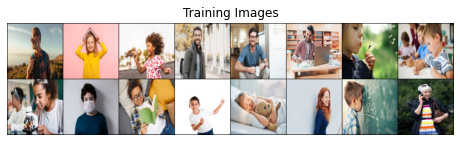

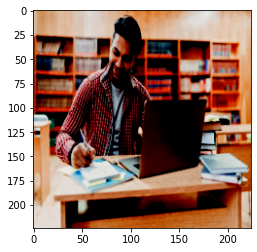

Label: 0


In [ ]:
#Visualize some training images
'''
DO NOT ALTER THE FOLLOWING CODE
'''
real_batch = next(iter(train_dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(torchvision.utils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()
plt.imshow(real_batch[0][5].permute(1,2,0), vmin=0, vmax=255)
plt.show()
print(f"Label: {real_batch[1][5]}")

In [ ]:
'''
DO NOT ALTER THE FOLLOWING CODE
'''
def make_train_step(model, optimizer, loss_fn):
  '''
  INPUT: model, optimizer, loss function
  OUTPUT: train step
  '''
  def train_step(x,y):
    '''
    This function is used to train the model and update the model parameters. Do not change this function
    '''
    #make prediction
    yhat = model(x)
    #enter train mode
    model.train()
    #compute loss
    loss = loss_fn(yhat,y)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return loss
  return train_step

In [ ]:
'''
DO NOT ALTER THE FOLLOWING CODE
'''
def train_model(model,n_epochs, loss_fn, train_step):
  '''
  This is the main function which is used to train the model, update weights, calculate loss and save the best model
  '''
  train_losses = []
  val_losses = []
  epoch_train_losses = []
  epoch_val_losses = []
  for epoch in range(n_epochs):
    epoch_loss = 0
    for i ,data in tqdm(enumerate(train_dataloader), total = len(train_dataloader)): #iterate ove batches
      x_batch , y_batch = data
      x_batch = x_batch.to('cuda') #move to gpu
      y_batch = y_batch.unsqueeze(1).float() #convert target to same nn output shape
      y_batch = y_batch.to('cuda') #move to gpu
      loss = train_step(x_batch, y_batch)
      epoch_loss += loss/len(train_dataloader) 
      train_losses.append(loss.cpu().detach().numpy())
    epoch_train_losses.append(epoch_loss)
    print('\nEpoch : {}, train loss : {}'.format(epoch+1,epoch_loss))
    #validation does not require gradient
    with torch.no_grad():
      cum_loss = 0
      for x_batch, y_batch in valid_dataloader:
        x_batch = x_batch.to('cuda')
        y_batch = y_batch.unsqueeze(1).float() #convert target to same nn output shape
        y_batch = y_batch.to('cuda')
        model.eval()#model to eval mode
        yhat = model(x_batch)
        val_loss = loss_fn(yhat,y_batch)
        cum_loss += loss/len(valid_dataloader)
        val_losses.append(val_loss.item())
      epoch_val_losses.append(cum_loss)
      print('Epoch : {}, val loss : {}'.format(epoch+1,cum_loss))   
      best_loss = min(epoch_val_losses)  
      #save best model
      if cum_loss <= best_loss:
        best_model_wts = model.state_dict()  
  #load best model
  model.load_state_dict(best_model_wts)
  return model, train_losses,val_losses

def plot_losses(train_losses,val_losses):
  '''
  This function can be used to plot the training and validation losses. You can use this 
  function to analyse the losses and judge if model was overfitting or if model shows some 
  unusual behaviour. 
  '''
  plt.plot(train_losses, label='Training loss')
  plt.plot(val_losses, label='Validation loss')
  plt.legend()
  plt.show()

def inference(model,test_data):
  '''
  As we are doing binary classification, this function uses sigmoid to change class probabilities 
  to either 0 or 1 class. 
  '''
  y_pred = []
  y_true = []
  for idx in range(1, len(test_data)):
    y_true.append( test_data[idx][1])
    sample = torch.unsqueeze(test_data[idx][0], dim=0).to('cuda')
    if torch.sigmoid(model(sample)) < 0.5:
      y_pred.append(0)
    else:
      y_pred.append(1)
  return y_pred, y_true

def calc_loss(model, n_epochs):
  '''
  This function drives the training function, assigns the loss fuction and sets the optimiizer.
  '''
  loss_fn = BCEWithLogitsLoss() 
  optimizer = torch.optim.Adam(model.parameters()) 
  train_step = make_train_step(model, optimizer, loss_fn)
  trained_model, train_losses, val_losses = train_model(model,n_epochs, loss_fn, train_step)
  return trained_model

def calc_accuracy(trained_model):
  '''
  This function is used for returning the calculated accuracies.
  '''
  y_pred, y_true = inference(trained_model,test_data)
  target_names = ['Adults', 'Kids']
  print('the accuracy is',accuracy_score(y_true, y_pred))
  print(classification_report(y_true, y_pred, target_names=target_names))
  print('the balanced accuracy is',balanced_accuracy_score(y_true, y_pred))
  return accuracy_score(y_true, y_pred)

#### **Consider the following code snippet for a Neural Network**

This Network is a very simple Network for your reference to implement a Neural Network of any given architecture. 


```
class Net(Module):   
    
    def __init__(self):
        super(Net, self).__init__()
        self.cnn_layers = Sequential(
            # Defining a 2D convolution layer
            Conv2d(NUM_CHANNELS, IMAGE_SIZE, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(IMAGE_SIZE),
            MaxPool2d(kernel_size=2, stride=2),
            # Defining another 2D convolution layer
            Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(32),
            MaxPool2d(kernel_size=2, stride=2),
        )
        self.linear_layers = Sequential(
            Linear(100352, 1)
        )
    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

# defining the model
model = Net()
# defining the optimizer
optimizer = Adam(model.parameters(), lr=0.07)
# defining the loss function
criterion = CrossEntropyLoss()
# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
    
print(model)

trained_model = calc_loss(model, n_epochs)
calc_accuracy(trained_model)
```



#### **(1) Build a CNN for the following Model Architecture [3 marks]**


```
Net(
  (cnn_1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (cnn_2): Sequential(
    (0): Conv2d(32, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (cnn_3): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (cnn_4): Sequential(
    (0): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (cnn_5): Sequential(
    (0): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (cnn_6): Sequential(
    (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fully_1): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=50176, out_features=4096, bias=True)
  )
  (fully_2): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=4096, out_features=4096, bias=True)
  )
  (fully_3): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=4096, out_features=1000, bias=True)
  )
  (fully_4): Sequential(
    (0): Linear(in_features=1000, out_features=1, bias=True)
  )
)
```

The codebase is as follows:


In [ ]:
from torch.nn.modules.conv import ConvTranspose2d, Conv2d
class Net(Module):   
    def __init__(self):
        super(Net, self).__init__()
        '''
        Write the 6 CNNs and 4 fully connected CNNs here:
        '''
        self.cnn_layers = Sequential(
            # Defining a 2D convolution layer
            Conv2d(3, 32 , kernel_size=3, stride=1, padding=1),
            BatchNorm2d(32),
            MaxPool2d(kernel_size=2, stride=2),

            Conv2d(32, 256, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(256),
            MaxPool2d(kernel_size=2, stride=2),

            Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(512),

            Conv2d(512, 256, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(256),

            Conv2d(256, 128, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(128),

            Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(64),
            MaxPool2d(kernel_size=2, stride=2)

        )
        self.linear_layers = Sequential(
            Dropout(),
            Linear(50176, 4096),

            Dropout(),
            Linear(4096, 4096),

            Dropout(),
            Linear(4096, 1000),

            Dropout(),
            Linear(1000, 1),

        )
    def forward(self, x):
        '''
        Define the forward pass
        '''
        #ENTER CODE HERE
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x
'''
DO NOT ALTER THE FOLLOWING CODE
'''
model = Net()
optimizer = Adam(model.parameters(), lr=0.07)
criterion = CrossEntropyLoss()
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
print(model)
trained_model = calc_loss(model, n_epochs) #train the model
calc_accuracy(trained_model) # report the accuracy 

Net(
  (cnn_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine

100%|██████████| 34/34 [02:01<00:00,  3.57s/it]


Epoch : 1, train loss : 147.4390411376953


Epoch : 1, val loss : 105.560546875


100%|██████████| 34/34 [00:08<00:00,  3.91it/s]


Epoch : 2, train loss : 74.16512298583984


Epoch : 2, val loss : 49.60282897949219


100%|██████████| 34/34 [00:08<00:00,  3.97it/s]


Epoch : 3, train loss : 77.32146453857422


Epoch : 3, val loss : 9.045659065246582


100%|██████████| 34/34 [00:08<00:00,  3.92it/s]


Epoch : 4, train loss : 29.212818145751953


Epoch : 4, val loss : 34.34587478637695


100%|██████████| 34/34 [00:09<00:00,  3.72it/s]


Epoch : 5, train loss : 16.8367919921875


Epoch : 5, val loss : 16.195587158203125


100%|██████████| 34/34 [00:08<00:00,  3.89it/s]


Epoch : 6, train loss : 14.06284236907959


Epoch : 6, val loss : 13.201038360595703


100%|██████████| 34/34 [00:08<00:00,  3.79it/s]


Epoch : 7, train loss : 11.195975303649902


Epoch : 7, val loss : 13.0108060836792


100%|██████████| 34/34 [00:08<00:00,  3.84it/s]


Epoch : 8, train loss : 10.90644645690918


Epoch : 8, val loss : 3.4134719371795654


100%|██████████| 34/34 [00:08<00:00,  3.82it/s]


Epoch : 9, train loss : 9.132003784179688


Epoch : 9, val loss : 7.349693775177002


100%|██████████| 34/34 [00:08<00:00,  3.79it/s]


Epoch : 10, train loss : 9.721800804138184


Epoch : 10, val loss : 14.533674240112305


100%|██████████| 34/34 [00:09<00:00,  3.75it/s]


Epoch : 11, train loss : 13.139936447143555


Epoch : 11, val loss : 5.638243675231934


100%|██████████| 34/34 [00:08<00:00,  3.83it/s]


Epoch : 12, train loss : 15.872647285461426


Epoch : 12, val loss : 19.71466827392578


100%|██████████| 34/34 [00:08<00:00,  3.85it/s]


Epoch : 13, train loss : 32.64326858520508


Epoch : 13, val loss : 73.87152862548828


100%|██████████| 34/34 [00:08<00:00,  3.87it/s]


Epoch : 14, train loss : 37.809532165527344


Epoch : 14, val loss : 28.892494201660156


100%|██████████| 34/34 [00:08<00:00,  3.85it/s]


Epoch : 15, train loss : 67.3951416015625


Epoch : 15, val loss : 58.3505859375


100%|██████████| 34/34 [00:08<00:00,  3.81it/s]


Epoch : 16, train loss : 82.62986755371094


Epoch : 16, val loss : 151.99832153320312


100%|██████████| 34/34 [00:08<00:00,  3.84it/s]


Epoch : 17, train loss : 75.37447357177734


Epoch : 17, val loss : 69.885498046875


100%|██████████| 34/34 [00:08<00:00,  3.82it/s]


Epoch : 18, train loss : 141.04962158203125


Epoch : 18, val loss : 249.5191192626953


100%|██████████| 34/34 [00:08<00:00,  3.81it/s]


Epoch : 19, train loss : 195.60887145996094


Epoch : 19, val loss : 410.58978271484375


100%|██████████| 34/34 [00:08<00:00,  3.83it/s]


Epoch : 20, train loss : 352.20947265625


Epoch : 20, val loss : 126.03019714355469


100%|██████████| 34/34 [00:09<00:00,  3.72it/s]


Epoch : 21, train loss : 514.92724609375


Epoch : 21, val loss : 964.4716186523438


100%|██████████| 34/34 [00:08<00:00,  3.84it/s]


Epoch : 22, train loss : 601.8077392578125


Epoch : 22, val loss : 959.6888427734375


100%|██████████| 34/34 [00:08<00:00,  3.84it/s]


Epoch : 23, train loss : 490.5875244140625


Epoch : 23, val loss : 141.82131958007812


100%|██████████| 34/34 [00:08<00:00,  3.86it/s]


Epoch : 24, train loss : 225.33859252929688


Epoch : 24, val loss : 424.9578857421875


100%|██████████| 34/34 [00:08<00:00,  3.79it/s]


Epoch : 25, train loss : 184.57667541503906


Epoch : 25, val loss : 269.9775085449219


100%|██████████| 34/34 [00:08<00:00,  3.84it/s]


Epoch : 26, train loss : 172.78724670410156


Epoch : 26, val loss : 74.99441528320312


100%|██████████| 34/34 [00:08<00:00,  3.82it/s]


Epoch : 27, train loss : 151.44241333007812


Epoch : 27, val loss : 135.34861755371094


100%|██████████| 34/34 [00:08<00:00,  3.84it/s]


Epoch : 28, train loss : 111.23295593261719


Epoch : 28, val loss : 53.38748550415039


100%|██████████| 34/34 [00:09<00:00,  3.72it/s]


Epoch : 29, train loss : 84.01261138916016


Epoch : 29, val loss : 131.39523315429688


100%|██████████| 34/34 [00:09<00:00,  3.76it/s]


Epoch : 30, train loss : 83.58482360839844


Epoch : 30, val loss : 53.749114990234375


100%|██████████| 34/34 [00:08<00:00,  3.83it/s]


Epoch : 31, train loss : 78.68254089355469


Epoch : 31, val loss : 68.04647064208984


100%|██████████| 34/34 [00:08<00:00,  3.84it/s]


Epoch : 32, train loss : 76.49220275878906


Epoch : 32, val loss : 93.31906127929688


100%|██████████| 34/34 [00:08<00:00,  3.83it/s]


Epoch : 33, train loss : 62.097774505615234


Epoch : 33, val loss : 24.66403579711914


100%|██████████| 34/34 [00:08<00:00,  3.85it/s]


Epoch : 34, train loss : 45.7093391418457


Epoch : 34, val loss : 24.789308547973633


100%|██████████| 34/34 [00:09<00:00,  3.77it/s]


Epoch : 35, train loss : 29.7122802734375


Epoch : 35, val loss : 56.257755279541016


100%|██████████| 34/34 [00:08<00:00,  3.85it/s]


Epoch : 36, train loss : 23.948740005493164


Epoch : 36, val loss : 10.984820365905762


100%|██████████| 34/34 [00:08<00:00,  3.85it/s]


Epoch : 37, train loss : 17.467618942260742


Epoch : 37, val loss : 16.970067977905273


100%|██████████| 34/34 [00:08<00:00,  3.86it/s]


Epoch : 38, train loss : 16.094207763671875


Epoch : 38, val loss : 20.241771697998047


100%|██████████| 34/34 [00:08<00:00,  3.81it/s]


Epoch : 39, train loss : 16.491718292236328


Epoch : 39, val loss : 6.772701263427734


100%|██████████| 34/34 [00:09<00:00,  3.76it/s]


Epoch : 40, train loss : 8.003385543823242


Epoch : 40, val loss : 4.743283271789551


100%|██████████| 34/34 [00:08<00:00,  3.84it/s]


Epoch : 41, train loss : 9.735715866088867


Epoch : 41, val loss : 13.779399871826172


100%|██████████| 34/34 [00:08<00:00,  3.85it/s]


Epoch : 42, train loss : 6.494388103485107


Epoch : 42, val loss : 4.458642959594727


100%|██████████| 34/34 [00:08<00:00,  3.85it/s]


Epoch : 43, train loss : 5.134119987487793


Epoch : 43, val loss : 6.830612659454346


100%|██████████| 34/34 [00:08<00:00,  3.81it/s]


Epoch : 44, train loss : 5.812450885772705


Epoch : 44, val loss : 16.721508026123047


100%|██████████| 34/34 [00:08<00:00,  3.84it/s]


Epoch : 45, train loss : 4.4134931564331055


Epoch : 45, val loss : 7.984278678894043


100%|██████████| 34/34 [00:08<00:00,  3.84it/s]


Epoch : 46, train loss : 4.357517242431641


Epoch : 46, val loss : 3.0432381629943848


100%|██████████| 34/34 [00:08<00:00,  3.85it/s]


Epoch : 47, train loss : 5.006443977355957


Epoch : 47, val loss : 1.69646155834198


100%|██████████| 34/34 [00:08<00:00,  3.84it/s]


Epoch : 48, train loss : 4.440022945404053


Epoch : 48, val loss : 1.9845654964447021


100%|██████████| 34/34 [00:09<00:00,  3.73it/s]


Epoch : 49, train loss : 2.99127459526062


Epoch : 49, val loss : 3.7236952781677246


100%|██████████| 34/34 [00:08<00:00,  3.84it/s]


Epoch : 50, train loss : 2.0637171268463135


Epoch : 50, val loss : 2.516557216644287
the accuracy is 0.5462184873949579
              precision    recall  f1-score   support

      Adults       0.54      0.59      0.56        59
        Kids       0.56      0.50      0.53        60

    accuracy                           0.55       119
   macro avg       0.55      0.55      0.55       119
weighted avg       0.55      0.55      0.55       119

the balanced accuracy is 0.5466101694915254


0.5462184873949579

#### **(2) Activation Functions [3 marks]**
Plug in the following Activation Functions:

1. ReLU
2. SiLU
3. Sigmoid
4. Tanh
5. ELU


Your Network Architecture should be as follows:



```
Net(
  (cnn_1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (cnn_2): Sequential(
    (0): Conv2d(32, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (cnn_3): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (cnn_4): Sequential(
    (0): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (cnn_5): Sequential(
    (0): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (cnn_6): Sequential(
    (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fully_1): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=50176, out_features=4096, bias=True)
    (2): YOUR ACTIVATION FUNCTION COMES HERE
  )
  (fully_2): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=4096, out_features=4096, bias=True)
    (2): YOUR ACTIVATION FUNCTION COMES HERE
  )
  (fully_3): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=4096, out_features=1000, bias=True)
    (2): YOUR ACTIVATION FUNCTION COMES HERE
  )
  (fully_4): Sequential(
    (0): Linear(in_features=1000, out_features=1, bias=True)
  )
)
```








In [ ]:
'''
Build the Network Architecture: (keep in mind the activation functions)
Try it out for ReLU, SiLU, Sigmoid, Tanh, ELU individually
'''
from torch.nn.modules.conv import ConvTranspose2d, Conv2d
from torch.nn import ReLU
class Net(Module):   
    def __init__(self):
        super(Net, self).__init__()
        '''
        Write the 6 CNNs and 4 fully connected CNNs here
        '''
        #ENTER CODE HERE
        self.cnn_layers = Sequential(
            # Defining a 2D convolution layer
            Conv2d(3, 32 , kernel_size=3, stride=1, padding=1),
            BatchNorm2d(32),
            MaxPool2d(kernel_size=2, stride=2),

            Conv2d(32, 256, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(256),
            MaxPool2d(kernel_size=2, stride=2),

            Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(512),

            Conv2d(512, 256, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(256),

            Conv2d(256, 128, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(128),

            Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(64),
            MaxPool2d(kernel_size=2, stride=2)

        )
        self.linear_layers = Sequential(
            Dropout(),
            Linear(50176, 4096),
            ReLU(),

            Dropout(),
            Linear(4096, 4096),
            ReLU(),

            Dropout(),
            Linear(4096, 1000),
            ReLU(),

            Dropout(),
            Linear(1000, 1),

        )
    def forward(self, x):
        '''
        Define the forward pass : 
        '''
        #ENTER CODE HERE
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x
'''
DO NOT ALTER THE FOLLOWING CODE
'''
model = Net()
optimizer = Adam(model.parameters(), lr=0.07)
criterion = CrossEntropyLoss()
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
print(model)
trained_model = calc_loss(model, n_epochs) #train the model
calc_accuracy(trained_model) # report the accuracy 

Net(
  (cnn_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine

100%|██████████| 34/34 [00:09<00:00,  3.68it/s]


Epoch : 1, train loss : 2.601146697998047


Epoch : 1, val loss : 0.9441830515861511


100%|██████████| 34/34 [00:09<00:00,  3.48it/s]


Epoch : 2, train loss : 0.9859794974327087


Epoch : 2, val loss : 1.0688544511795044


100%|██████████| 34/34 [00:09<00:00,  3.72it/s]


Epoch : 3, train loss : 0.770379900932312


Epoch : 3, val loss : 0.6494972705841064


100%|██████████| 34/34 [00:09<00:00,  3.71it/s]


Epoch : 4, train loss : 0.8474104404449463


Epoch : 4, val loss : 0.9062288403511047


100%|██████████| 34/34 [00:09<00:00,  3.73it/s]


Epoch : 5, train loss : 0.7247031927108765


Epoch : 5, val loss : 0.7699189186096191


100%|██████████| 34/34 [00:09<00:00,  3.55it/s]


Epoch : 6, train loss : 0.7085171341896057


Epoch : 6, val loss : 0.7824817895889282


100%|██████████| 34/34 [00:09<00:00,  3.75it/s]


Epoch : 7, train loss : 0.6766236424446106


Epoch : 7, val loss : 0.5488598346710205


100%|██████████| 34/34 [00:08<00:00,  3.79it/s]


Epoch : 8, train loss : 0.7006441354751587


Epoch : 8, val loss : 0.8590806722640991


100%|██████████| 34/34 [00:09<00:00,  3.76it/s]


Epoch : 9, train loss : 0.7574368715286255


Epoch : 9, val loss : 0.7979271411895752


100%|██████████| 34/34 [00:09<00:00,  3.74it/s]


Epoch : 10, train loss : 0.6126728057861328


Epoch : 10, val loss : 0.45291170477867126


100%|██████████| 34/34 [00:09<00:00,  3.66it/s]


Epoch : 11, train loss : 0.6620667576789856


Epoch : 11, val loss : 0.7670709490776062


100%|██████████| 34/34 [00:09<00:00,  3.55it/s]


Epoch : 12, train loss : 0.662987470626831


Epoch : 12, val loss : 0.5434718728065491


100%|██████████| 34/34 [00:09<00:00,  3.76it/s]


Epoch : 13, train loss : 0.6791802048683167


Epoch : 13, val loss : 0.7134965658187866


100%|██████████| 34/34 [00:09<00:00,  3.74it/s]


Epoch : 14, train loss : 0.6948124766349792


Epoch : 14, val loss : 0.40356671810150146


100%|██████████| 34/34 [00:09<00:00,  3.69it/s]


Epoch : 15, train loss : 0.5640061497688293


Epoch : 15, val loss : 0.8307348489761353


100%|██████████| 34/34 [00:09<00:00,  3.74it/s]


Epoch : 16, train loss : 0.6815824508666992


Epoch : 16, val loss : 0.6117281317710876


100%|██████████| 34/34 [00:09<00:00,  3.75it/s]


Epoch : 17, train loss : 0.5763456225395203


Epoch : 17, val loss : 0.6908228397369385


100%|██████████| 34/34 [00:09<00:00,  3.75it/s]


Epoch : 18, train loss : 0.7501770853996277


Epoch : 18, val loss : 0.5508629679679871


100%|██████████| 34/34 [00:09<00:00,  3.51it/s]


Epoch : 19, train loss : 0.6151017546653748


Epoch : 19, val loss : 0.3602146804332733


100%|██████████| 34/34 [00:09<00:00,  3.77it/s]


Epoch : 20, train loss : 0.5213842391967773


Epoch : 20, val loss : 0.4907999634742737


100%|██████████| 34/34 [00:09<00:00,  3.77it/s]


Epoch : 21, train loss : 0.47823527455329895


Epoch : 21, val loss : 0.4105992913246155


100%|██████████| 34/34 [00:09<00:00,  3.74it/s]


Epoch : 22, train loss : 0.4687531292438507


Epoch : 22, val loss : 0.25634849071502686


100%|██████████| 34/34 [00:09<00:00,  3.56it/s]


Epoch : 23, train loss : 0.4217933118343353


Epoch : 23, val loss : 0.17373967170715332


100%|██████████| 34/34 [00:09<00:00,  3.74it/s]


Epoch : 24, train loss : 0.543631374835968


Epoch : 24, val loss : 0.2747892141342163


100%|██████████| 34/34 [00:09<00:00,  3.74it/s]


Epoch : 25, train loss : 0.3998242914676666


Epoch : 25, val loss : 0.22855357825756073


100%|██████████| 34/34 [00:09<00:00,  3.76it/s]


Epoch : 26, train loss : 0.3407652676105499


Epoch : 26, val loss : 0.32642582058906555


100%|██████████| 34/34 [00:09<00:00,  3.55it/s]


Epoch : 27, train loss : 0.2909618616104126


Epoch : 27, val loss : 1.2940930128097534


100%|██████████| 34/34 [00:09<00:00,  3.73it/s]


Epoch : 28, train loss : 0.5877411961555481


Epoch : 28, val loss : 0.4277879595756531


100%|██████████| 34/34 [00:09<00:00,  3.73it/s]


Epoch : 29, train loss : 0.5585528612136841


Epoch : 29, val loss : 0.15846596658229828


100%|██████████| 34/34 [00:09<00:00,  3.76it/s]


Epoch : 30, train loss : 0.30311185121536255


Epoch : 30, val loss : 0.14579375088214874


100%|██████████| 34/34 [00:10<00:00,  3.18it/s]


Epoch : 31, train loss : 0.18393106758594513


Epoch : 31, val loss : 0.22965165972709656


100%|██████████| 34/34 [00:09<00:00,  3.77it/s]


Epoch : 32, train loss : 0.3248629570007324


Epoch : 32, val loss : 0.13681654632091522


100%|██████████| 34/34 [00:09<00:00,  3.76it/s]


Epoch : 33, train loss : 0.3013860881328583


Epoch : 33, val loss : 0.11545252799987793


100%|██████████| 34/34 [00:09<00:00,  3.75it/s]


Epoch : 34, train loss : 0.2964346408843994


Epoch : 34, val loss : 0.5107163786888123


100%|██████████| 34/34 [00:09<00:00,  3.75it/s]


Epoch : 35, train loss : 0.33940377831459045


Epoch : 35, val loss : 0.2875449061393738


100%|██████████| 34/34 [00:09<00:00,  3.56it/s]


Epoch : 36, train loss : 0.265414834022522


Epoch : 36, val loss : 0.3129769563674927


100%|██████████| 34/34 [00:08<00:00,  3.80it/s]


Epoch : 37, train loss : 0.29867562651634216


Epoch : 37, val loss : 0.2472170889377594


100%|██████████| 34/34 [00:09<00:00,  3.77it/s]


Epoch : 38, train loss : 0.23700949549674988


Epoch : 38, val loss : 0.22072234749794006


100%|██████████| 34/34 [00:09<00:00,  3.77it/s]


Epoch : 39, train loss : 0.2323935627937317


Epoch : 39, val loss : 0.45534491539001465


100%|██████████| 34/34 [00:09<00:00,  3.66it/s]


Epoch : 40, train loss : 0.2999589741230011


Epoch : 40, val loss : 0.2074231058359146


100%|██████████| 34/34 [00:08<00:00,  3.79it/s]


Epoch : 41, train loss : 0.28452208638191223


Epoch : 41, val loss : 0.2139875888824463


100%|██████████| 34/34 [00:09<00:00,  3.77it/s]


Epoch : 42, train loss : 0.5950632095336914


Epoch : 42, val loss : 0.32466137409210205


100%|██████████| 34/34 [00:09<00:00,  3.76it/s]


Epoch : 43, train loss : 0.4222673773765564


Epoch : 43, val loss : 0.24946612119674683


100%|██████████| 34/34 [00:09<00:00,  3.76it/s]


Epoch : 44, train loss : 0.35008910298347473


Epoch : 44, val loss : 0.423076868057251


100%|██████████| 34/34 [00:09<00:00,  3.49it/s]


Epoch : 45, train loss : 0.24009285867214203


Epoch : 45, val loss : 0.18409302830696106


100%|██████████| 34/34 [00:09<00:00,  3.74it/s]


Epoch : 46, train loss : 0.13287371397018433


Epoch : 46, val loss : 0.13221126794815063


100%|██████████| 34/34 [00:09<00:00,  3.74it/s]


Epoch : 47, train loss : 0.3971901834011078


Epoch : 47, val loss : 0.8606558442115784


100%|██████████| 34/34 [00:09<00:00,  3.76it/s]


Epoch : 48, train loss : 0.5130791664123535


Epoch : 48, val loss : 0.42473268508911133


100%|██████████| 34/34 [00:09<00:00,  3.57it/s]


Epoch : 49, train loss : 0.6464115977287292


Epoch : 49, val loss : 0.6688838601112366


100%|██████████| 34/34 [00:09<00:00,  3.70it/s]


Epoch : 50, train loss : 0.5938149094581604


Epoch : 50, val loss : 0.6012362837791443
the accuracy is 0.5462184873949579
              precision    recall  f1-score   support

      Adults       0.53      0.81      0.64        59
        Kids       0.61      0.28      0.39        60

    accuracy                           0.55       119
   macro avg       0.57      0.55      0.51       119
weighted avg       0.57      0.55      0.51       119

the balanced accuracy is 0.5484463276836158


0.5462184873949579

1. **Plot the accuracies for each activation function**

In [ ]:
#ENTER CODE HERE

2. **Which function performs better? Justify.**

ANSWER-

### **Part II: Custom Activation Functions**

#### **(1) Implement any activation function of your OWN and DO NOT USE any predefined PyTorch Activation Functions [ 3 marks]**



```
class custom_activation_function(nn.Module):
    '''
    Implementation of custom activation function
    '''
    def __init__(self, in_features, alpha = None):
        '''
        Initialization
        '''

    def forward(self, x):
        '''
        Forward pass of the function.
        '''

af = custom_activation_function(<some_parameters>)
x = torch.randn(256) # random tensor
x = af(x)
```

Your Network Architecture should be as follows:

```
Net(
  (cnn_1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (cnn_2): Sequential(
    (0): Conv2d(32, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (cnn_3): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (cnn_4): Sequential(
    (0): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (cnn_5): Sequential(
    (0): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (cnn_6): Sequential(
    (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fully_1): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=50176, out_features=4096, bias=True)
  )
  (fully_2): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=4096, out_features=4096, bias=True)
  )
  (fully_3): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=4096, out_features=1000, bias=True)
  )
  (fully_4): Sequential(
    (0): Linear(in_features=1000, out_features=1, bias=True)
  )
  (a1): custom_activation_function()
  (a2): custom_activation_function()
  (a3): custom_activation_function()
)
```

Hint: Here, we are asking you to apply Custom activation functions to the Fully Connected Layers in the forward pass of the Network


#### **(2) Implement any COMPLEX activation function of your OWN and DO NOT USE any predefined PyTorch Activation Functions {CMPUT 566 only} [ 5 marks]**

Implement any one of the following activation functions 

1. [Soft exponential](https://arxiv.org/pdf/1602.01321.pdf)
2. [BReLU](https://arxiv.org/pdf/1709.04054.pdf)





### **Part III: ResNet [6 marks]**

#### **(1) Implement the following **pretrained ResNet variants****


1. ResNet18
2. ResNet50
3. ResNet152

You can refer the ResNet documentation in the RESOURCES tab.


In [ ]:
model_resnet_variant = <assign this to a pretrained resnet model> #ENTER CODE HERE

'''
DO NOT ALTER THE FOLLOWING CODE
'''
#freeze all the model parameters
for params in model_resnet_variant.parameters():
  params.requires_grad_ = False
'''
DO NOT ALTER THE ABOVE CODE
'''

nr_filters = <input features of last fully connected layer> #ENTER CODE HERE
model_resnet_variant.fc = nn.Linear(nr_filters, 1)
model_resnet_variant = model_resnet_variant.to(device)

trained_model = calc_loss(model_resnet_variant, n_epochs)
calc_accuracy(trained_model)

#### **(2) Which ResNet performs better? Justify.**

Your answer -  

### **Part IV: Class Imbalance and Sampling [ 5 marks]**




**Consider the imbalanced data and run the following CNN with and without Weighted Random Sampler**



```
class Net(Module):   
    def __init__(self):
        super(Net, self).__init__()

        self.cnn_layers = Sequential(
            # Defining a 2D convolution layer
            Conv2d(NUM_CHANNELS, IMAGE_SIZE, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(IMAGE_SIZE),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
            # Defining another 2D convolution layer
            Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(32),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
        )

        self.linear_layers = Sequential(
            Linear(100352, 1)
        )

    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        #x = x.view(x.size(0), -1)

        return x
        
```


**NOTE:** 
1. Change the main and test paths to the imbalanced dataset.
2. Sampler can be loaded to data loader as follows:



```
sampler_W = <ENTER CODE for weighted sampler>

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=2, sampler = sampler_W)
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, num_workers=2)
```

**Has the accuracy gone up or down? Why? Explain your answer.**


### **Part V: Data Augmentation{CMPUT 466 only}[ 5 marks]**
1. **What is Data Augmentation? How does it help in combating the data imbalance issue?**

Answer - 

2. **Rotate** the image clockwise by **30** degrees

In [ ]:
# importing an image from the imbalanced dataset
image_path = <import any random image from the dataset> #ENTER THE PATH
'''
DO NOT ALTER THE FOLLOWING CODE
HOWEVER, IF YOU WANT TO ANOTHER LIBRARY, FEEL FREE TO USE IT TOO.
JUST MAKE SURE TO DO THE AUGMENTATION AND THEN SHOW THE AUGMENTED IMAGE
'''

import imageio
import imgaug as ia
import imgaug.augmenters as iaa
%matplotlib inline
image = imageio.imread(image_path)
ia.imshow(image)

# Your code to rotate the image then show it. Use ia.imshow(image) if using imgaug library

##

3. Add **Gaussian noise** to the image. 


In [ ]:
## YOUR CODE TO ADD GAUSSIAN NOISE TO THE IMAGE

4. Convolve the image by applying [**Sobel Edge Detection**](https://www.projectrhea.org/rhea/index.php/An_Implementation_of_Sobel_Edge_Detection) filter. You can apply either X or Y directional kernel and use any library.


In [ ]:
## YOUR CODE FOR SOBEL EDGE DETECTION

5. Think of **two cases** where augmentations might **not be useful**. For instance, in digits classification, applying a flipping augmentation for the digit 2 might be of no use. 

Answer - 